In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely as shy
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint
import fiona
from scipy.spatial import cKDTree
import numpy as np

pd.options.display.max_rows = 4
%matplotlib inline
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #window

In [2]:
#Filepaths
work = r"D:"
laptop = r"C:\Users\jerem"
origin = work

In [3]:
# Open signal intersection stata dta file
fp = r"\Box Sync\Policy Evaluation\input_data\DOT_traffic_signals_Oct_2018\signal_controllers_clean.dta"
df = pd.read_stata(origin+fp)
df.head(3)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup
0,1.0,199793.609300002,986336.149,ALLEN STREET,CANAL STREET,,,0
1,2.0,202206.161899999,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0
2,3.0,201790.0942,982805.618399993,AVENUE OF THE AMERICAS,LISPENARD STREET,WEST BROADWAY,,0


In [4]:
# Convert coordinates into float
df['y'] = df['y'].astype(float)
df['x'] = df['x'].astype(float)
# Put the latitude and longtitude 
df['Coordinates'] = list(zip(df.x, df.y))
df['Coordinates'] = df['Coordinates'].apply(Point)
df1 = gpd.GeoDataFrame(df, geometry='Coordinates')

In [5]:
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002)
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999)


In [6]:
df1.crs = {'init' :'epsg:2263'}

In [7]:
df1.crs

{'init': 'epsg:2263'}

In [8]:
df1.head()

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates
0,1.0,199793.6093,986336.1490,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002)
1,2.0,202206.1619,982769.3310,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999)
...,...,...,...,...,...,...,...,...,...
3,4.0,201529.9618,982812.2555,AVENUE OF THE AMERICAS,WALKER STREET,,,0,POINT (982812.255500004 201529.961799994)
4,5.0,201226.1097,982816.3956,AVENUE OF THE AMERICAS,WHITE STREET,CHURCH STREET,,0,POINT (982816.395600006 201226.109699994)


In [9]:
# Open LPIs shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\VZV_Leading Pedestrian Interval Signals\geo_export_0c63b43f-83c0-4834-aa91-2c564c1bff2c.shp"
df2 = gpd.read_file(origin+fp)
df2.head(3)

,cross_stre,date_insta,time_insta,lat,long,main_stree,geometry
0,Dreiser loop East,2018-08-01,00:00:00.000,40.878465,-73.828273,Co-op City Blvd,POINT (-73.82827338235253 40.87846542795222)
1,West 119 St,2018-08-08,00:00:00.000,40.803958,-73.948271,Lenox Avenue,POINT (-73.94827133431397 40.80395846158952)
2,West 120 St,2018-08-08,00:00:00.000,40.804587,-73.947812,Lenox Avenue,POINT (-73.94781210658503 40.80458679730486)


In [10]:
df2.crs

{'init': 'epsg:4326'}

In [11]:
# Reproeject LPIS shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df2 = df2.to_crs({'init': 'epsg:2263'})

In [12]:
# Check that 
df2.crs

{'init': 'epsg:2263'}

In [13]:
# Create ID variable
df2['LPIS_ID'] = df2.index
df2.head(3)


,cross_stre,date_insta,time_insta,lat,long,main_stree,geometry,LPIS_ID
0,Dreiser loop East,2018-08-01,00:00:00.000,40.878465,-73.828273,Co-op City Blvd,POINT (1031739.000154228 259373.000004255),0
1,West 119 St,2018-08-08,00:00:00.000,40.803958,-73.948271,Lenox Avenue,POINT (998570.9998893011 232184.9999184268),1
2,West 120 St,2018-08-08,00:00:00.000,40.804587,-73.947812,Lenox Avenue,POINT (998697.9999633889 232414.0001165908),2


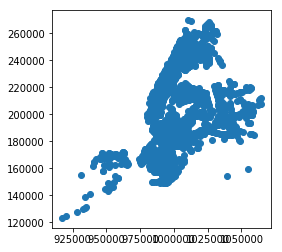

In [14]:
df2.plot()

In [15]:
# ckdnearest function
# from "https://gist.github.com/jhconning/63a34a51acff83d116adc52308faf240"
def ckdnearest(gdA, gdB, bcol):
    """
    This function takes geodataframes: `gdA` and `gdB` and 
    a column name `bcol`. Both dataframes are assumed to have a `geometry` column. 
    It finds the nearest neighbor from each location in `gdA` to a 
    nearest neighbor in `gdB`.  

    It returns a two-column pandas dataframe with a 'distance' (here rounded to nearest foot)
    and the value of the `bcol` in `gdB'  (e.g. 'school_name')
    """
    
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(int),
                             'bcol' : gdB.loc[idx, bcol].values })
    return df


In [16]:
df1[['distance_to_LPIS','nearest_LPIS']] = ckdnearest(df1, df2,'LPIS_ID')
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,nearest_LPIS
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,1915
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,2016


In [17]:
print(df1['nearest_LPIS'].isnull())

0        False
1        False
         ...  
13211    False
13212    False
Name: nearest_LPIS, Length: 13213, dtype: bool


In [18]:
df1[pd.isnull(df1).any(axis=1)]

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,nearest_LPIS


In [19]:
print(df1['distance_to_LPIS'].isnull().sum())

0


In [20]:
# I am not sure why 63 signal intersections are not able to be paired with the nearest LPIS

In [21]:
# Open Streets shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\nyclion_points_2263/nyclion_points_2263.shp"
df3 = gpd.read_file(origin+fp)
df3.head(3)

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,...,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Leng,geometry
0,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,699,596,716,599,699,596,716,2251001000000,396.030947,POINT (1010964.446978778 241812.2614034563)
1,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,699,596,716,599,699,596,716,2251001000000,396.030947,POINT (1011040.463264077 241747.2881445785)
2,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,699,596,716,599,699,596,716,2251001000000,396.030947,POINT (1011116.479549377 241682.3148857006)


In [22]:
df3.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [23]:
df1[['distance_to_Street','nearest_Street']] = ckdnearest(df1, df3,'OBJECTID')
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,1915,7,91705
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,2016,17,95035


In [24]:
print(df1['nearest_Street'].isnull().sum())

0


In [25]:
print(df1['distance_to_Street'].isnull().sum())

0


In [26]:
# Open Schools shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\school_private_public_2263\school_private_public_2263.shp"
df4 = gpd.read_file(origin+fp)
df4.head(3)

,uid,idagency,facname,opname,address,city,zipcode,bcode,facsubgrp,factype,capacity,util,xcoord,ycoord,geometry
0,192.0,321000145390,Our Lady Of Refuge School,Our Lady Of Refuge School,2708 Briggs Avenue,Bronx,10458,36005,Non-Public K-12 Schools,Elementary School - Non-public,NaN,267.0,1.014359e+06,254977.5176,POINT (1014358.6833 254977.5176)
1,294.0,332000226225,Yeshiva Toldos Yesuscher,Yeshiva Toldos Yesuscher,1531 63 Street,Brooklyn,11219,36047,Non-Public K-12 Schools,Elementary School - Non-public,NaN,74.0,9.857114e+05,166689.5140,POINT (985711.4182 166689.514)
2,2233.0,331400225670,Ohel Elozer,Ohel Elozer,263 Classon Ave-Ste 4b,Brooklyn,11205,36047,Non-Public K-12 Schools,High School - Non-public,NaN,161.0,9.951838e+05,191390.1394,POINT (995183.844 191390.1394)


In [27]:
df4.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [28]:
df1[['distance_to_Sch','nearest_Sch']] = ckdnearest(df1, df4,'uid')
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,1915,7,91705,529,3433.0
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,2016,17,95035,795,38150.0


In [29]:
print(df1['nearest_Sch'].isnull().sum())

0


In [30]:
print(df1['distance_to_Sch'].isnull().sum())

0


In [31]:
# Open VZV Left turn calming shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\left_turn_traffic_calming_shapefile\left_turn_traffic_calming.shp"
df5 = gpd.read_file(origin+fp)
df5.head(3)

,treatment_,completion,geometry
0,Quick Kurb to X-walk,2017-12-08,POINT (-73.97604825017703 40.75144139179798)
1,"Daylighting, Box markings, (1) 6' Rubber speed...",2018-04-12,POINT (-73.82577379991478 40.75635805716421)
2,Quick Kurb to X-walk,2016-06-30,POINT (-73.97719688637932 40.7643236906894)


In [32]:
df5.crs

{'init': 'epsg:4326'}

In [33]:
df5.bounds

,minx,miny,maxx,maxy
0,-73.976048,40.751441,-73.976048,40.751441
1,-73.825774,40.756358,-73.825774,40.756358
...,...,...,...,...
230,-73.805648,40.704672,-73.805648,40.704672
231,-73.897563,40.707759,-73.897563,40.707759


In [34]:
# Reproeject VZV Left turn calming shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df5 = df5.to_crs({'init': 'epsg:2263'})

In [35]:
df5.crs

{'init': 'epsg:2263'}

In [36]:
# Create ID variable
df5['LTC_ID'] = df5.index
df5.head(3)

,treatment_,completion,geometry,LTC_ID
0,Quick Kurb to X-walk,2017-12-08,POINT (990886.2363875993 213047.939427546),0
1,"Daylighting, Box markings, (1) 6' Rubber speed...",2018-04-12,POINT (1032518.714146682 214886.3347008746),1
2,Quick Kurb to X-walk,2016-06-30,POINT (990566.7655698524 217741.2961825352),2


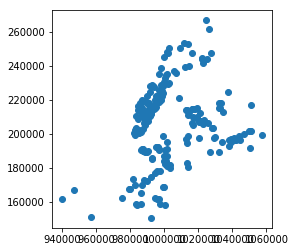

In [37]:
df5.plot()

In [38]:
df1[['distance_to_LTC','nearest_LTC']] = ckdnearest(df1, df5,'LTC_ID')
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,1915,7,91705,529,3433.0,1183,191
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,2016,17,95035,795,38150.0,411,77


In [39]:
print(df1['nearest_LTC'].isnull().sum())

0


# Open VZV Street Improvement shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\street_improvement_projects_intersections_shapefile\street_improvement_projects_intersections.shp"
df6 = gpd.read_file(origin+fp)
df6.tail(3)

df6.crs

# Reproeject VZV Street Improvement shapefile to EPSG 2263: NAD83 / New York Long Island (ftUS)
df6 = df6.to_crs({'init': 'epsg:2263'})

df6.crs

# Create ID variable
df6['StImpro_ID'] = df6.index
df6.head(3)

df6.plot()

df1[['distance_to_StImpro','nearest_StImpro']] = ckdnearest(df1, df6,'StImpro_ID')
df1.head(2)

In [40]:
# Open Bikeroute shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\bike_routes_points_2263\bike_routes_points_2263.shp"
df7 = gpd.read_file(origin+fp)
df7.head(3)

,tf_facilit,comments,bikedir,ft_facilit,objectid_1,allclasses,date_instd,time_instd,lanecount,segment_id,boro,street,date_modda,time_modda,tostreet,fromstreet,onoffst,geometry
0,Protected Path,None,L,None,1.0,I,None,00:00:00.000,1.0,33547,1.0,9 AV,None,00:00:00.000,W 31 ST,W 16 ST,ON,POINT (984139.5802614246 211708.657997195)
1,Protected Path,None,L,None,1.0,I,None,00:00:00.000,1.0,33547,1.0,9 AV,None,00:00:00.000,W 31 ST,W 16 ST,ON,POINT (984140.0661334711 211709.5320271455)
2,Protected Path,None,L,None,1.0,I,None,00:00:00.000,1.0,33547,1.0,9 AV,None,00:00:00.000,W 31 ST,W 16 ST,ON,POINT (984140.5520055175 211710.4060570961)


In [41]:
df7.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [42]:
df1[['distance_to_bikeroute','nearest_bikeroute']] = ckdnearest(df1, df7,'segment_id')
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,nearest_LPIS,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC,distance_to_bikeroute,nearest_bikeroute
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,1915,7,91705,529,3433.0,1183,191,3,162688
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,2016,17,95035,795,38150.0,411,77,230,31876


In [43]:
print(df1['nearest_bikeroute'].isnull().sum())

0


In [44]:
#For some reason bike route has not issues with missing

In [45]:
# Open Truckroute shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\truckroute_points_2263\truckroute_points_2263.shp"
df8 = gpd.read_file(origin+fp)
df8.head(3)

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,...,Restrictio,NYC_Reg,LtdLocal,ThruExwy,LocalBrg,LocalTunl,ThruBrg,ThruTunl,Shape_Leng,geometry
0,1,TRINITY PLACE,None,0,U,None,B,None,W,DOT,...,None,"NYCDOT Traffic Rules, Section 4-13-(d)(2)",None,None,None,None,None,None,61.384654,POINT (980855.2233999987 197527.1545999364)
1,2,WATER STREET,None,0,U,None,B,None,T,DOT,...,None,"NYCDOT Traffic Rules, Section 4-13-(d)(2)",None,None,None,None,None,None,243.748254,POINT (980827.536599993 195309.7279999424)
2,2,WATER STREET,None,0,U,None,B,None,T,DOT,...,None,"NYCDOT Traffic Rules, Section 4-13-(d)(2)",None,None,None,None,None,None,243.748254,POINT (980922.8409135042 195340.0114579148)


In [46]:
print(df8['OBJECTID'].isnull().sum())

0


In [47]:
df8.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [48]:
df1[['distance_to_truckroute','nearest_truckroute']] = ckdnearest(df1, df8,'OBJECTID')
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,...,distance_to_Street,nearest_Street,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC,distance_to_bikeroute,nearest_bikeroute,distance_to_truckroute,nearest_truckroute
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,...,7,91705,529,3433.0,1183,191,3,162688,26,892
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,...,17,95035,795,38150.0,411,77,230,31876,17,2024


In [49]:
print(df1['nearest_truckroute'].isnull().sum())

0


In [50]:
# Open Borough shapefile
fp = r"\Box Sync\Policy Evaluation\input_data\nyc_boroughs_2263\nyc_boroughs_2263.shp"
df9 = gpd.read_file(origin+fp)
df9.head(3)

,bcode,bname,name,namelsad,geometry
0,36005,Bronx,Bronx,Bronx County,(POLYGON ((1008982.068976385 272752.8735210547...
1,36047,Brooklyn,Kings,Kings County,(POLYGON ((978869.3811487257 186863.7807399245...
2,36061,Manhattan,New York,New York County,(POLYGON ((1007701.483091666 258286.8905491272...


In [51]:
df9.crs = df1.crs
df1 = gpd.sjoin(df1,df9[['bname', 'geometry']], how='inner', op='intersects')


In [52]:
df1.head(2)

,intersection_id,y,x,st1_name,st2_name,st3_name,st4_name,dup,Coordinates,distance_to_LPIS,...,distance_to_Sch,nearest_Sch,distance_to_LTC,nearest_LTC,distance_to_bikeroute,nearest_bikeroute,distance_to_truckroute,nearest_truckroute,index_right,bname
0,1.0,199793.6093,986336.149,ALLEN STREET,CANAL STREET,,,0,POINT (986336.149 199793.609300002),276,...,529,3433.0,1183,191,3,162688,26,892,2,Manhattan
1,2.0,202206.1619,982769.331,AVENUE OF THE AMERICAS,LAIGHT STREET,CANAL STREET,,0,POINT (982769.331 202206.161899999),592,...,795,38150.0,411,77,230,31876,17,2024,2,Manhattan


In [53]:
list(df1.select_dtypes(include=['object']).columns)

['st1_name',
 'st2_name',
 'st3_name',
 'st4_name',
 'Coordinates',
 'nearest_bikeroute',
 'bname']

In [54]:
df1['st1_name'] = df1['st1_name'].astype(str)
df1['st2_name'] = df1['st2_name'].astype(str)
df1['st3_name'] = df1['st3_name'].astype(str)
df1['st4_name'] = df1['st4_name'].astype(str)
df1['Coordinates'] = df1['Coordinates'].astype(str)
df1['nearest_bikeroute'] = df1['nearest_bikeroute'].astype(str)
df1['bname'] = df1['bname'].astype(str)

In [55]:
fp =  r"\Box Sync\Policy Evaluation\working_data\signal_intersection.dta"
df1.to_stata(origin+fp)